In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import impyute as impy
import statsmodels.api as sm
from datetime import datetime
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from datetime import date
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from statistics import pstdev

In [34]:
cleaned_dataset = pd.read_csv('my_cleaned_dataset.csv')


In [35]:
dataset = cleaned_dataset[["date", "location",'new_cases','stringency_index', "new_deaths",'icu_patients','people_vaccinated','positive_rate', 'new_vaccinations', 'new_tests' , 'total_boosters']]
dataset['location'] = dataset['location'].astype('category')
dataset['date'] = pd.to_datetime(dataset['date'])
dataset.index = pd.to_datetime(dataset.date)
dataset.index.freq = dataset.index.inferred_freq

C:\Users\User\AppData\Local\Temp/ipykernel_13588/412158069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['location'] = dataset['location'].astype('category')
C:\Users\User\AppData\Local\Temp/ipykernel_13588/412158069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['date'] = pd.to_datetime(dataset['date'])


In [36]:
# take non-numerical variables
non_numerical_variables = [
    'location',
    'date'
]

numerical_variables = [
'new_cases','stringency_index', "new_deaths",'icu_patients','people_vaccinated','positive_rate', 'new_vaccinations', 'new_tests' , 'total_boosters'
]

cleaned_dataset = dataset.copy()

obj_dataset = cleaned_dataset[non_numerical_variables].copy()
num_dataset = cleaned_dataset[numerical_variables].copy()

num_dataset = pd.DataFrame(num_dataset, columns=numerical_variables)


num_dataset = np.log(num_dataset)
num_dataset = num_dataset.diff()
num_dataset = num_dataset.diff()

cleaned_dataset = pd.concat([obj_dataset, pd.DataFrame(data=num_dataset, columns=numerical_variables)], axis=1)

In [37]:
def replace_nans(dataset):
    # for each country
    new_dataset = pd.DataFrame()

    for country in dataset['location'].unique():
        country_dataset = dataset[dataset['location'] == country]

        for variable in numerical_variables:
            for index, row in country_dataset.iterrows():
                if pd.isna(row[variable]) or row[variable] == float('inf') or row[variable] == float('-inf'):
                    previous_timestamp = index - pd.Timedelta(days=1)
                    if previous_timestamp in country_dataset.index and pd.isna(country_dataset.loc[previous_timestamp, variable]) == False:
                        country_dataset.at[index, variable] = country_dataset.at[previous_timestamp, variable]
                    else:
                        country_dataset.at[index, variable] = 0
    
        new_dataset = pd.concat([new_dataset, country_dataset], axis=0)

    return new_dataset

cleaned_dataset= replace_nans(cleaned_dataset)

In [38]:
is_NaN = cleaned_dataset.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = cleaned_dataset[row_has_NaN]

print(rows_with_NaN.shape)

(0, 11)


In [39]:
data_list = [d for _, d in cleaned_dataset.groupby(['location'])]
for variable in numerical_variables:
    if variable == 'new_deaths':
        cleaned_dataset['new_deaths_lag1'] = cleaned_dataset['new_deaths'].shift(1)
        cleaned_dataset['new_deaths_lag2'] = cleaned_dataset['new_deaths'].shift(2)
    else:
        cleaned_dataset[variable + '_0'] = cleaned_dataset[variable].shift(1)
    cleaned_dataset = cleaned_dataset.dropna()

cleaned_dataset.head(50)

,location,date,new_cases,stringency_index,new_deaths,icu_patients,people_vaccinated,positive_rate,new_vaccinations,new_tests,...,new_cases_0,stringency_index_0,new_deaths_lag1,new_deaths_lag2,icu_patients_0,people_vaccinated_0,positive_rate_0,new_vaccinations_0,new_tests_0,total_boosters_0
date,,,,,,,,,,,,,,,,,,,,,
2020-03-06,Austria,2020-03-06,-0.251314,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,-0.575364,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2020-03-07,Austria,2020-03-07,0.384846,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,-0.251314,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2020-03-08,Austria,2020-03-08,-0.498175,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.384846,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2020-03-09,Austria,2020-03-09,0.036139,0.559487,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,-0.498175,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2020-03-10,Austria,2020-03-10,0.559028,-0.559487,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.036139,0.559487,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2020-03-11,Austria,2020-03-11,-0.408931,0.452359,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.559028,-0.559487,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2020-03-12,Austria,2020-03-12,-0.360589,-0.338073,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,-0.408931,0.452359,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2020-03-13,Austria,2020-03-13,1.416447,0.226056,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,-0.360589,-0.338073,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2020-03-14,Austria,2020-03-14,-1.573904,-0.340343,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,1.416447,0.226056,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0


In [40]:
cleaned_dataset = cleaned_dataset[cleaned_dataset["location"] != 'Ireland']
cleaned_dataset = cleaned_dataset[cleaned_dataset["location"] != 'Malta']
cleaned_dataset = cleaned_dataset[cleaned_dataset["location"] != 'Luxembourg']

dummies = pd.get_dummies(cleaned_dataset.location)
cleaned_dataset = pd.concat([cleaned_dataset, dummies], axis = 1)
cleaned_dataset.drop_duplicates(inplace = True)
countries = cleaned_dataset['location'].unique()

cleaned_dataset = cleaned_dataset.drop(columns=['location'])
cleaned_dataset.columns

Index(['date', 'new_cases', 'stringency_index', 'new_deaths', 'icu_patients',
       'people_vaccinated', 'positive_rate', 'new_vaccinations', 'new_tests',
       'total_boosters', 'new_cases_0', 'stringency_index_0',
       'new_deaths_lag1', 'new_deaths_lag2', 'icu_patients_0',
       'people_vaccinated_0', 'positive_rate_0', 'new_vaccinations_0',
       'new_tests_0', 'total_boosters_0', 'Austria', 'Belgium', 'Bulgaria',
       'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Ireland', 'Italy', 'Luxembourg', 'Malta', 'Netherlands',
       'Portugal', 'Romania', 'Serbia', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'United Kingdom', 'United States'],
      dtype='object')

In [41]:
# split into train and test
training_date_limit = date(2021, 10, 1)

cleaned_dataset.index = pd.to_datetime(cleaned_dataset.date)
cleaned_dataset.index.freq = cleaned_dataset.index.inferred_freq

train_dataset = cleaned_dataset[cleaned_dataset['date'].dt.date < training_date_limit]
test_dataset = cleaned_dataset[cleaned_dataset['date'].dt.date >= training_date_limit]

In [42]:
numerical_variables_with_lags = cleaned_dataset.columns.tolist()
numerical_variables_with_lags = [x for x in numerical_variables_with_lags if x not in ['continent', 'location','date']]

In [43]:
cleaned_dataset

,date,new_cases,stringency_index,new_deaths,icu_patients,people_vaccinated,positive_rate,new_vaccinations,new_tests,total_boosters,...,Netherlands,Portugal,Romania,Serbia,Slovenia,Spain,Sweden,Switzerland,United Kingdom,United States
date,,,,,,,,,,,,,,,,,,,,,
2020-03-06,2020-03-06,-0.251314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2020-03-07,2020-03-07,0.384846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2020-03-08,2020-03-08,-0.498175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2020-03-09,2020-03-09,0.036139,0.559487,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2020-03-10,2020-03-10,0.559028,-0.559487,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-28,2021-10-28,-0.464198,0.000000,-0.820675,-0.009224,-0.000108,-0.117783,-0.080922,-0.457954,-0.006731,...,0,0,0,0,0,0,0,0,0,1
2021-10-29,2021-10-29,0.463834,0.000000,0.268763,-0.126087,0.000016,-0.117783,0.078808,-0.457954,-0.002860,...,0,0,0,0,0,0,0,0,0,1
2021-10-30,2021-10-30,-1.420847,0.000000,-1.668878,0.128016,-0.000828,-0.117783,-1.215143,-0.457954,-0.032110,...,0,0,0,0,0,0,0,0,0,1


In [44]:
def random_forest_regression(country):
    best_score = -np.Infinity
    best_n_estimators = 3
    best_rfr_model = None

    # X = train_dataset[numerical_variables_with_lags].loc[train_dataset['location'] == country]
    X = train_dataset[numerical_variables_with_lags]
    X = X.drop(columns=['new_deaths'])
    # y = train_dataset['new_deaths'].loc[train_dataset['location'] == country]
    y = train_dataset['new_deaths']


    # show score
    X_test = test_dataset[numerical_variables_with_lags].loc[test_dataset[country] == 1]
    # X_test = test_dataset[numerical_variables_with_lags]
    # remove new_deaths from X_test
    X_test = X_test.drop(columns=['new_deaths'])
    y_test = test_dataset['new_deaths'].loc[test_dataset[country] == 1]
    # y_test = test_dataset['new_deaths']

    n_estimators = 3
    while n_estimators < 50:
        rfr = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
        rfr.fit(X, y)

        score = rfr.score(X_test, y_test)
        if score > best_score:
            best_score = score
            best_n_estimators = n_estimators
            best_rfr_model = rfr
        n_estimators = n_estimators + 1

    print("Country: {} Estimator number: {} - Random Forest Regression model Score: {}".format( country, best_n_estimators, best_score))

    predictions = best_rfr_model.predict(X_test)

    new_index = y_test.index
    predictions = pd.Series(predictions)
    predictions.index = new_index

    # plot predictions vs actual
    plt.xlabel("Date")
    plt.ylabel("New Deaths")

    ax1 = y_test.plot(color='blue', grid=True, label='Expected')
    ax2 = predictions.plot(color='red', grid=True,  label='Predicted')


    plt.legend()
    plt.show()

    return predictions

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Country: United States Estimator number: 46 - Random Forest Regression model Score: 0.6283543323816051


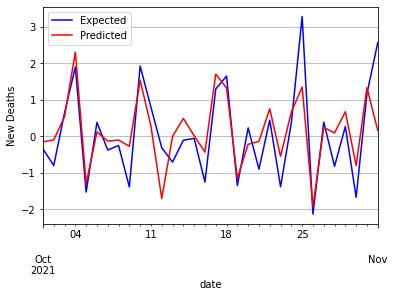

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Country: United States Estimator number: 46 - Random Forest Regression model Score: 0.6283543323816051


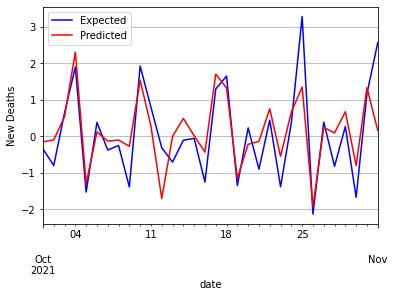

In [45]:
from datetime import timedelta

cleaned_dataset.index = pd.to_datetime(cleaned_dataset.date)
cleaned_dataset.index.freq = cleaned_dataset.index.inferred_freq

# get min date from svr_dataset
min_date = cleaned_dataset['date'].min()
max_date = cleaned_dataset['date'].max()


years = []
# for each year
for year in range(min_date.year, max_date.year + 1):
    years.append(year)

    rfr_years_dataset = cleaned_dataset[cleaned_dataset['date'].dt.year.isin([year])]

    # set training_date_limit last 160 days of year
    training_date_limit = rfr_years_dataset['date'].max() - timedelta(days=25)

    # split into train and test
    svr_train_dataset = rfr_years_dataset[rfr_years_dataset['date'].dt.date < training_date_limit]
    svr_test_dataset = rfr_years_dataset[rfr_years_dataset['date'].dt.date >= training_date_limit]

    random_forest_regression("United States")